# Problem Statement
The goal of this project is to predict the operating condition of “waterpoints” (water pumps) in Tanzania to promote access to clean, potable water. We will classify “waterpoints” into three categories: "functional" (operational and no repairs needed), "functional needs repair" (operational but in need of repairs), and "non-functional" (not operational).

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
import plotly.graph_objects as go
import pickle
import os

In [17]:
keep_cols = [
    'basin',
    'source',
    'gps_height',
    'latitude',
    'longitude',
    'payment_type',
    'funder',
    'scheme_management',
    'quantity',
    'recorded_by',
    'population',
    'amount_tsh',
    'installer',
    'public_meeting',
    'construction_year',
    'management',
    'extraction_type',
    'ward',
    'date_recorded',
    'permit',
    'water_quality'
]
dropped_cols = [
    "waterpoint_type",
    "waterpoint_type_group",
    "source_type",
    "source_class",
    "quantity_group",
    'num_private',
    "management_group",
    "district_code",
    "quality_group",
    "payment",
    "extraction_type_group",
    "extraction_type_class",
    "scheme_name",
    "subvillage",
    "region_code",
    "wpt_name"
]
kept_categorical_features = [
    'funder',
    'installer',
    'basin',
    'ward',
    'recorded_by',
    'scheme_management',
    'extraction_type',
    'management',
    'payment_type',
    'water_quality',
    'quantity',
    'source'
]
missing_values_continuous = {
    'amount_tsh':0,
    'date_recorded':0,
    'gps_height':0,
    'longitude':0,
    'latitude':-2.000000e-08,
    'population':0,
    'construction_year':0,
}

missing_values_categorical = [
    'not known',
    'unknown',
    'none',
    '-',
    '##',
    'not kno',
    'unknown installer'
]
missing_values_by_feature = missing_values_continuous

for feature in kept_categorical_features:
    missing_values_by_feature[feature] = missing_values_categorical

In [18]:
# Function to determine the prediction type(used for visualization)
def prediction_type(row):
    if row['true_label'] == 'functional':
        return 'True Functional' if row['predicted_label'] == 'functional' else 'False Functional'
    elif row['true_label'] == 'non functional':
        return 'True Nonfunctional' if row['predicted_label'] == 'non functional' else 'False Nonfunctional'
    elif row['true_label'] == 'functional needs repair':
        return 'True FNR' if row['predicted_label'] == 'functional needs repair' else 'False FNR'

# prediction type colors(also used for visualization)
categories_colors = {
    'True Functional': 'green',
    'False Functional': 'lightgreen',
    'True Nonfunctional': 'blue',
    'False Nonfunctional': 'lightblue',
    'True FNR': 'purple',
    'False FNR': 'violet'
}

# Function for plotting on a map
def plot_predictions(X_data, true_labels, predicted_labels, title, categories_colors, scope, width, height):
    data_with_predictions = X_data.copy()
    data_with_predictions['true_label'] = true_labels
    data_with_predictions['predicted_label'] = predicted_labels
    data_with_predictions['pred_type'] = data_with_predictions.apply(prediction_type, axis=1)

    fig = go.Figure()
    for category, color in categories_colors.items():
        filtered_data = data_with_predictions[data_with_predictions['pred_type'] == category]
        fig.add_trace(go.Scattergeo(
            lon = filtered_data['longitude'],
            lat = filtered_data['latitude'],
            text = filtered_data['pred_type'],
            marker = dict(size = 4, color = color, line_color = 'rgb(40,40,40)', line_width = 0.5, sizemode = 'area'),
            name = category
        ))

    fig.update_layout(title=title, geo=dict(scope=scope, landcolor='rgb(217, 217, 217)'), width=width, height=height)
    fig.show()

# Data Properties and Acquisition:
- Data Source: We obtained the dataset from the DrivenData competition, which provides comprehensive information about “waterpoints” in Tanzania.
- Features: The dataset consists of various features such as 'amount_tsh' (water head), 'gps_height' (altitude), 'region' (geographic location), 'population' (population around the well), 'construction_year' (year of construction), and many others.
- Labels: The labels are the operating conditions of the “waterpoints”, which include 'functional', 'functional needs repair', and 'non-functional'.

In [19]:
# File paths for feather files
train_label_path_feather = "./data/train_label.feather"
train_data_path_feather = "./data/train_data.feather"
test_data_path_feather = "./data/test_data.feather"

try:

    # Read in pre-parsed feather files
    train_label_df = pd.read_feather(train_label_path_feather)
    train_data_df = pd.read_feather(train_data_path_feather)
    test_data_df = pd.read_feather(test_data_path_feather)

except FileNotFoundError:
    # File paths for the CSV files
    train_label_path = './data/train_label.csv'
    train_data_path = './data/train_data.csv'
    test_data_path = './data/test_data.csv'

    # Loading the CSV files into pandas DataFrames
    train_label_df = pd.read_csv(
        train_label_path,
        usecols=["status_group"],
        # dtype={"status_group":"category"},
        dtype_backend="pyarrow"
    )
    train_data_df = pd.read_csv(
        train_data_path,
        usecols=keep_cols,
        na_values=missing_values_by_feature,
        parse_dates=["date_recorded"],
        dtype_backend="pyarrow"
    )
    test_data_df = pd.read_csv(
        test_data_path,
        usecols=keep_cols,
        na_values=missing_values_by_feature,
        parse_dates=["date_recorded"],
        dtype_backend="pyarrow"
    )
    train_label_df.to_feather(train_label_path_feather)
    train_data_df.to_feather(train_data_path_feather)
    test_data_df.to_feather(test_data_path_feather)

In [20]:
train_label_df

status_group
0          functional
1          functional
2          functional
3      non functional
4          functional
...               ...
59395      functional
59396      functional
59397      functional
59398      functional
59399      functional

[59400 rows x 1 columns]

In [21]:
train_data_df

amount_tsh date_recorded           funder  gps_height     installer  \
0          6000.0    2011-03-14            Roman        1390         Roman   
1            <NA>    2013-03-06          Grumeti        1399       GRUMETI   
2            25.0    2013-02-25     Lottery Club         686  World vision   
3            <NA>    2013-01-28           Unicef         263        UNICEF   
4            <NA>    2011-07-13      Action In A        <NA>       Artisan   
...           ...           ...              ...         ...           ...   
59395        10.0    2013-05-03  Germany Republi        1210           CES   
59396      4700.0    2011-05-07      Cefa-njombe        1212          Cefa   
59397        <NA>    2011-04-11             <NA>        <NA>          <NA>   
59398        <NA>    2011-03-08            Malec        <NA>          Musa   
59399        <NA>    2011-03-23       World Bank         191         World   

       longitude   latitude                    basin              ward  \
0      34.938093  -9.856322               Lake Nyasa          Mundindi   
1      34.698766  -2.147466            Lake Victoria             Natta   
2      37.460664  -3.821329                  Pangani           Ngorika   
3      38.486161 -11.155298  Ruvuma / Southern Coast          Nanyumbu   
4      31.130847  -1.825359            Lake Victoria        Nyakasimbi   
...          ...        ...                      ...               ...   
59395  37.169807  -3.253847                  Pangani  Masama Magharibi   
59396  35.249991  -9.070629                   Rufiji            Ikondo   
59397  34.017087  -8.750434                   Rufiji           Chimala   
59398  35.861315  -6.378573                   Rufiji      Mvumi Makulu   
59399  38.104048  -6.747464              Wami / Ruvu        Ngerengere   

       population  ...              recorded_by scheme_management permit  \
0             109  ...  GeoData Consultants Ltd               VWC  False   
1             280  ...  GeoData Consultants Ltd             Other   True   
2             250  ...  GeoData Consultants Ltd               VWC   True   
3              58  ...  GeoData Consultants Ltd               VWC   True   
4            <NA>  ...  GeoData Consultants Ltd              <NA>   True   
...           ...  ...                      ...               ...    ...   
59395         125  ...  GeoData Consultants Ltd       Water Board   True   
59396          56  ...  GeoData Consultants Ltd               VWC   True   
59397        <NA>  ...  GeoData Consultants Ltd               VWC  False   
59398        <NA>  ...  GeoData Consultants Ltd               VWC   True   
59399         150  ...  GeoData Consultants Ltd               VWC   True   

      construction_year  extraction_type   management payment_type  \
0                  1999          gravity          vwc     annually   
1                  2010          gravity          wug    never pay   
2                  2009          gravity          vwc   per bucket   
3                  1986      submersible          vwc    never pay   
4                  <NA>          gravity        other    never pay   
...                 ...              ...          ...          ...   
59395              1999          gravity  water board   per bucket   
59396              1996          gravity          vwc     annually   
59397              <NA>           swn 80          vwc      monthly   
59398              <NA>      nira/tanira          vwc    never pay   
59399              2002      nira/tanira          vwc   on failure   

      water_quality      quantity                source  
0              soft        enough                spring  
1              soft  insufficient  rainwater harvesting  
2              soft        enough                   dam  
3              soft           dry           machine dbh  
4              soft      seasonal  rainwater harvesting  
...             ...           ...                   ...  
59395          soft  

In [22]:
# Split training data to test model
X_train, X_test, y_train, y_test = train_test_split(train_data_df, train_label_df, test_size=0.2, random_state=42)

# Check for missing values in the training set
print(X_train.isnull().sum())
print(X_train.shape)

amount_tsh           33331
date_recorded            0
funder                2877
gps_height           16275
installer             2912
longitude             1433
latitude              1433
basin                    0
ward                     0
population           17048
public_meeting        2689
recorded_by              0
scheme_management     3103
permit                2439
construction_year    16503
extraction_type          0
management             456
payment_type          6521
water_quality         1490
quantity               629
source                  56
dtype: int64
(47520, 21)


# Handling Missing Values
Before training the models, we needed to handle any missing values in our dataset. First we we droped the feature which was missing the most values(scheme_name). Removing this column helped to simplify the model, potentially reducing the risk of overfitting. Next we identified numeric and categorical columns. This separation is crucial because numeric and categorical data generally require different types of preprocessing. 

For the numeric_features we employed a SimpleImputer with median strategy(to fill missing values with the median value) and a scaler (to standardize the features by removing the mean and scaling to unit variance).
For the categorical_features we utilized SimpleImputer with a most_frequent strategy(to fill missing values with the most frequent value;i.e. mode) and a one-hot encoder (to convert categorical variables into a format that can be used by machine learning algorithms). These transformers ensure that the appropriate preprocessing steps are applied to each type of data, improving the quality of the data fed into the model. 

Finally we used 'ColumnTransformer' to allow us to combine the two pipelines into a single preprocessor step. This makes the code more organized and ensures that each feature is preprocessed using the appropriate method. This step is key in ensuring that the preprocessing is applied uniformly across all features, maintaining consistency and improving model reliability.

In [25]:
# Identify numerical and categorical columns
numeric_features = train_data_df.select_dtypes(exclude=['string','datetime']).columns
categorical_features = train_data_df.select_dtypes(include=['string']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=3, weights='distance')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing to training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Training Models
## Evaluation Metrics: 
- Model performance will be evaluated using metrics such as accuracy, precision, recall, F1-score, and confusion matrices. Cross-validation will ensure robustness in model evaluation.
1. Accuracy: Accuracy is the proportion of correctly classified “waterpoints”. While important, it may not capture class imbalances effectively.
2. Precision: Precision measures the ratio of correctly predicted positive instances (functional needs repair or non-functional) to all predicted positive instances. It is valuable for assessing the accuracy of failure predictions.
3. Recall: Recall calculates the ratio of correctly predicted positive instances to all actual positive instances. It helps identify the model's ability to capture failures.
4. F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balanced measure of accuracy, especially in imbalanced datasets.
5. Cross-Validation: We will use k-fold cross-validation (typically k=5 or 10) to ensure the robustness of our model evaluation. Cross-validation involves splitting the dataset into k subsets, using k-1 for training and one for testing. This process is repeated k times, with each subset serving as the test set once. The results are averaged to provide a more reliable estimate of model performance.

### Decision Tree
- Decision trees will serve as our baseline model due to their simplicity and interpretability. We'll set the maximum depth to prevent overfitting and visualize the tree structure.

In [26]:
# Ensure that y_train and y_test are in the correct format
# If they are categorical, they should be converted to a consistent type (either all strings or all numeric)
y_train = y_train['status_group'].astype(str)
y_test = y_test['status_group'].astype(str)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_test_pred_dt = dt_classifier.predict(X_test_preprocessed)

# Replace 0, 1, 2 with class names
class_names = ['functional', 'non functional', 'functional needs repair']

Decision Tree Classifier Report:

                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      6457
         non functional       0.37      0.38      0.37       851
functional needs repair       0.76      0.76      0.76      4572

               accuracy                           0.75     11880
              macro avg       0.64      0.65      0.64     11880
           weighted avg       0.75      0.75      0.75     11880



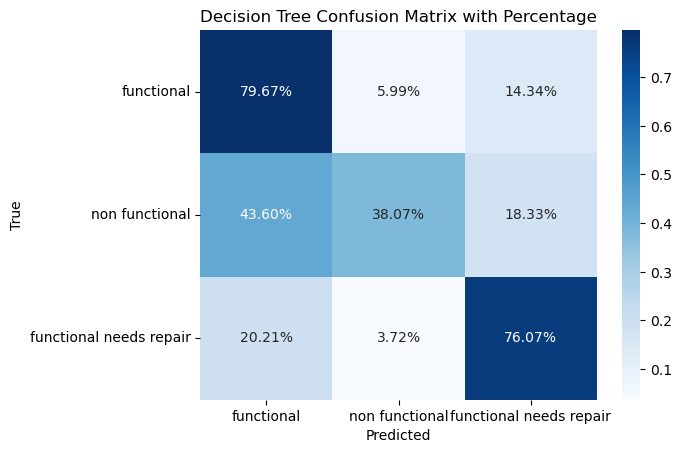

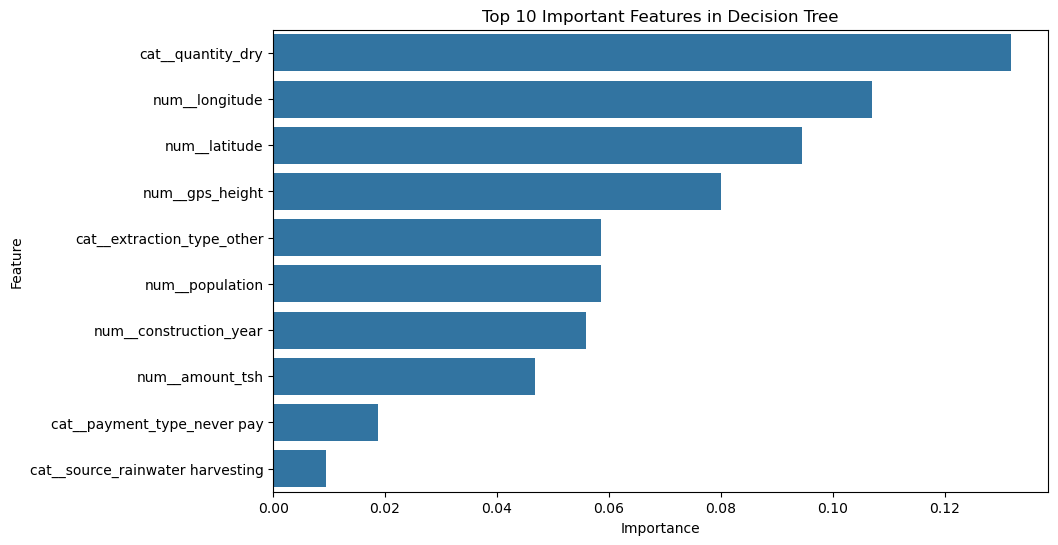

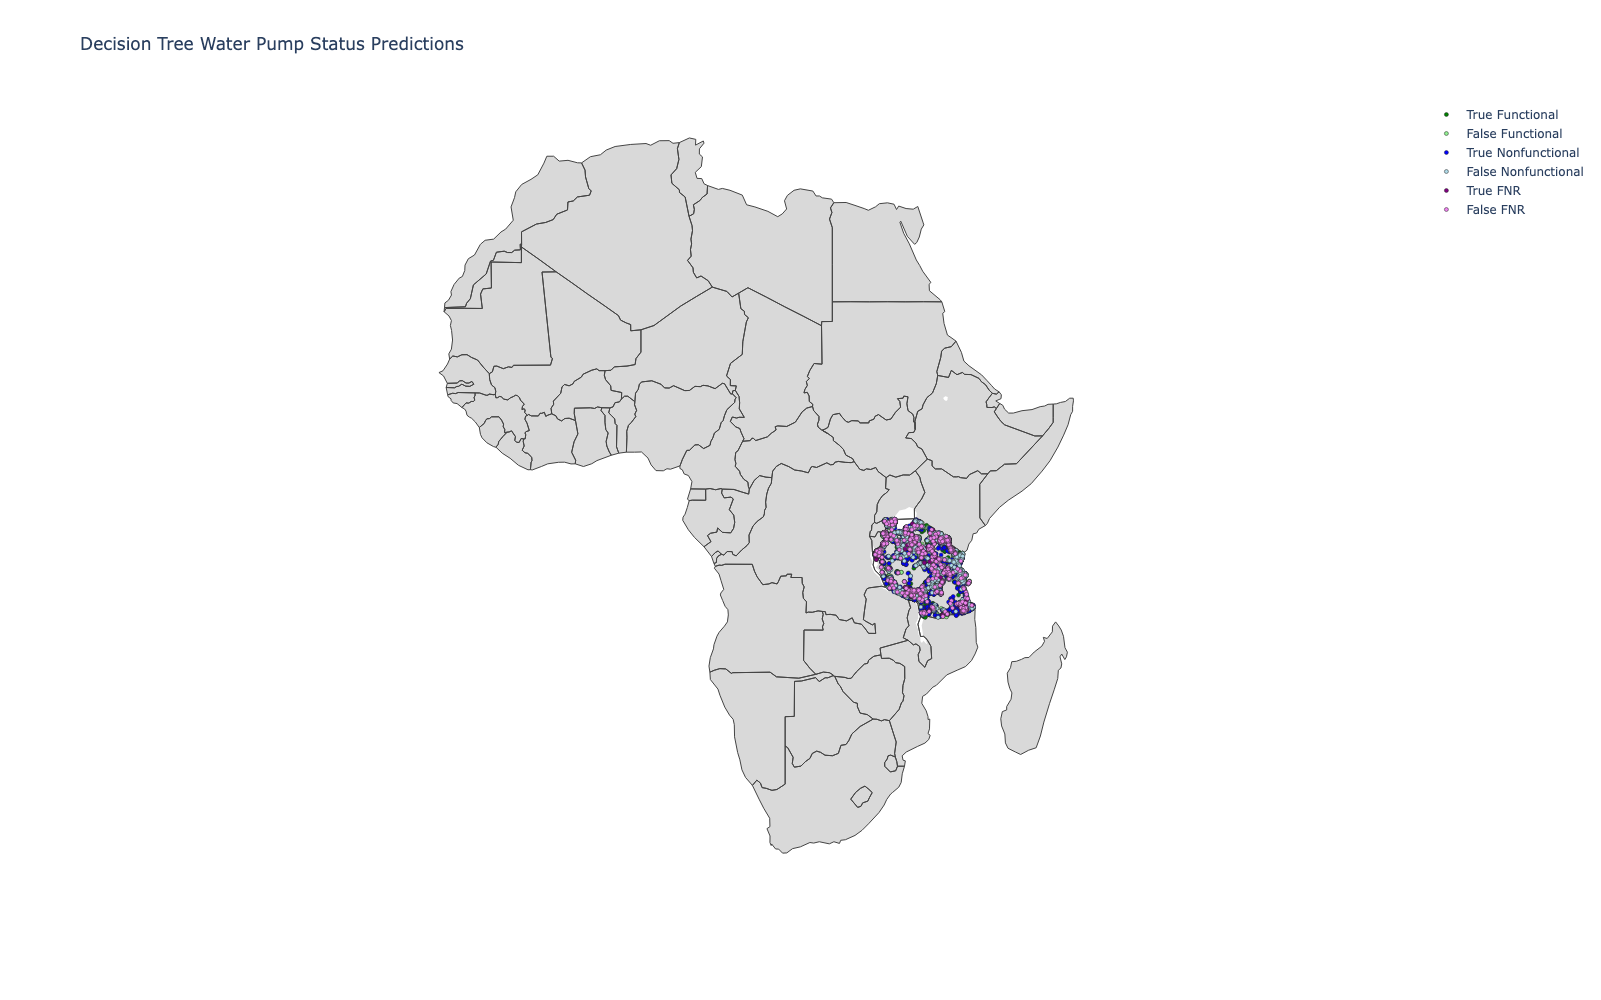

In [27]:
# Classification Report
print("Decision Tree Classifier Report:\n")
print(classification_report(y_test, y_test_pred_dt, target_names=class_names))

# Confusion Matrix with Percentages
cm = confusion_matrix(y_test, y_test_pred_dt)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix with Percentage')
plt.show()

# Feature Importance Visualization
feature_names = preprocessor.get_feature_names_out()  # Get feature names after preprocessing
importances = dt_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features in Decision Tree')
plt.show()

# Plot on Map
plot_predictions(X_test, y_test, y_test_pred_dt, 'Decision Tree Water Pump Status Predictions', categories_colors, 'africa', 1500, 1000)

### Random Forest
- Random forests are an ensemble method that combines multiple decision trees to improve predictive accuracy. We'll tune hyperparameters like the number of trees and maximum depth to optimize performance.
  - **Hyperparameter Tuning:** For each algorithm, we will conduct hyperparameter tuning using techniques like grid search or random search. This process involves systematically exploring different combinations of hyperparameters to find the optimal set that maximizes the chosen evaluation metric.

In [28]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_test_pred_rf = rf_classifier.predict(X_test_preprocessed)


Random Forest Classifier Report:

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6457
         non functional       0.50      0.34      0.41       851
functional needs repair       0.82      0.78      0.80      4572

               accuracy                           0.80     11880
              macro avg       0.71      0.67      0.68     11880
           weighted avg       0.79      0.80      0.80     11880



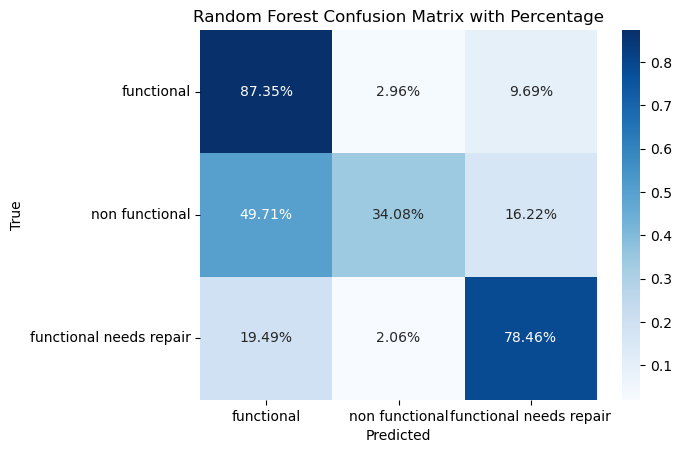

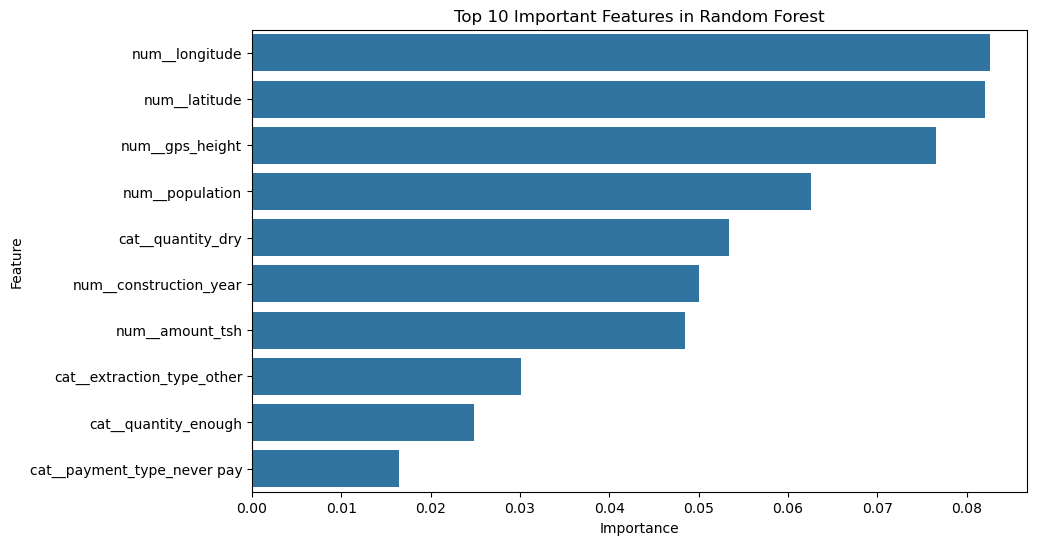

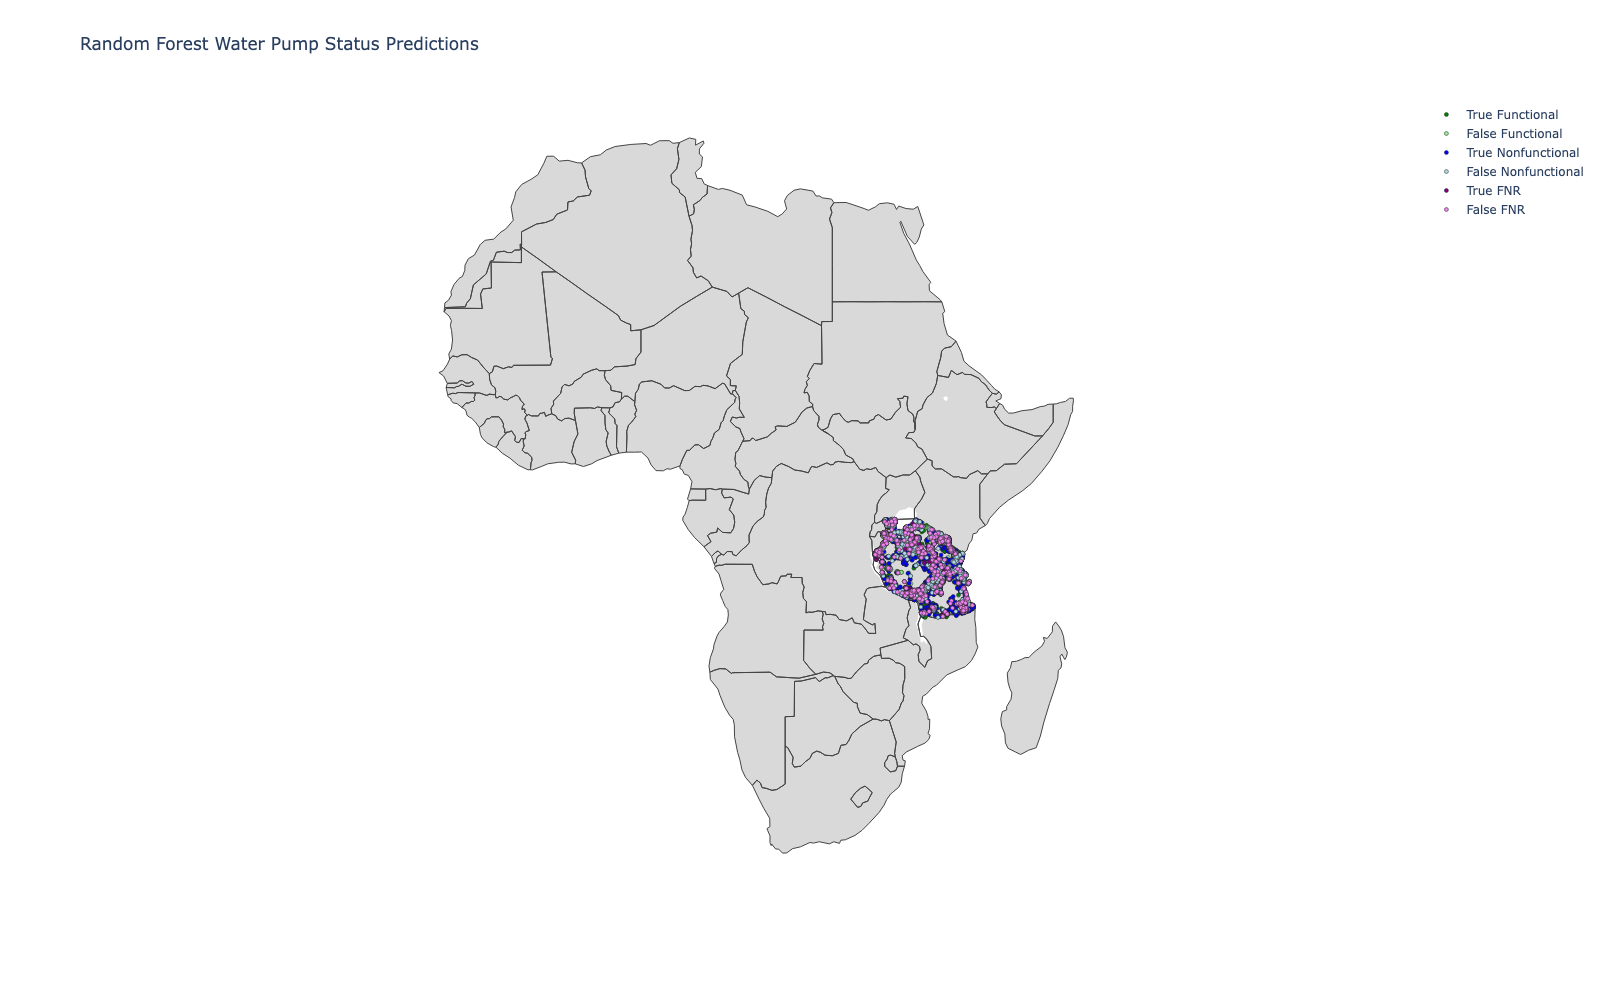

In [29]:
# Classification Report
print("Random Forest Classifier Report:\n")
print(classification_report(y_test, y_test_pred_rf, target_names=class_names))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
cm_rf_percentage = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix with Percentage')
plt.show()

# Feature Importance Visualization for Random Forest
importances_rf = rf_classifier.feature_importances_
importance_rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_rf_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features in Random Forest')
plt.show()

# Plot on Map
plot_predictions(X_test, y_test, y_test_pred_rf, 'Random Forest Water Pump Status Predictions', categories_colors, 'africa', 1500, 1000)

### Gradient Boosting
- Gradient boosting is another ensemble technique that sequentially builds decision trees, focusing on the previously misclassified instances. TODO: We'll explore models like XGBoost or LightGBM for their effectiveness.

In [58]:
# Instantiate the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42, subsample=0.3, verbose=1)

# Fit the classifier to the training data
gb_classifier.fit(X_train_preprocessed, y_train)

# Predict on the validation set
y_test_pred_gb = gb_classifier.predict(X_test_preprocessed)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8274           0.0516            1.88m
         2           0.7938           0.0429            1.82m
         3           0.7654           0.0338            1.81m
         4           0.7346           0.0237            1.83m
         5           0.7188           0.0262            1.81m
         6           0.6913           0.0138            1.78m
         7           0.6770           0.0167            1.76m
         8           0.6687           0.0155            1.74m
         9           0.6500           0.0099            1.73m
        10           0.6463           0.0138            1.72m
        20           0.5794           0.0092            1.59m
        30           0.5498           0.0031            1.44m
        40           0.5324           0.0050            1.29m
        50           0.5227           0.0023            1.16m
        60           0.5135           0.0027            1.05m
       

Gradient Boosting Classifier Report:

                         precision    recall  f1-score   support

             functional       0.76      0.90      0.82      6457
         non functional       0.55      0.23      0.33       851
functional needs repair       0.82      0.70      0.76      4572

               accuracy                           0.78     11880
              macro avg       0.71      0.61      0.64     11880
           weighted avg       0.77      0.78      0.76     11880



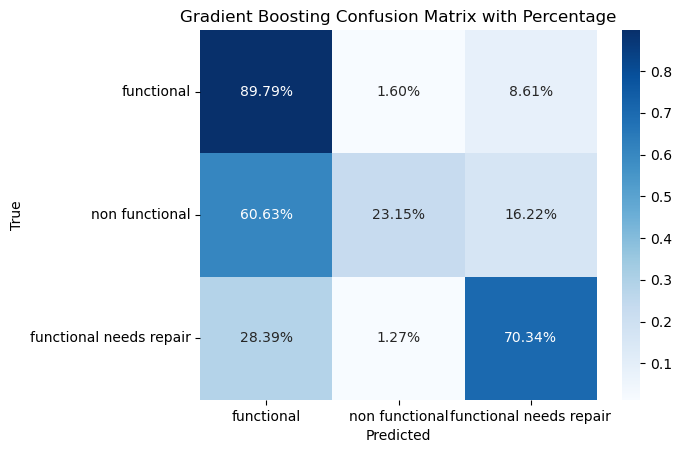

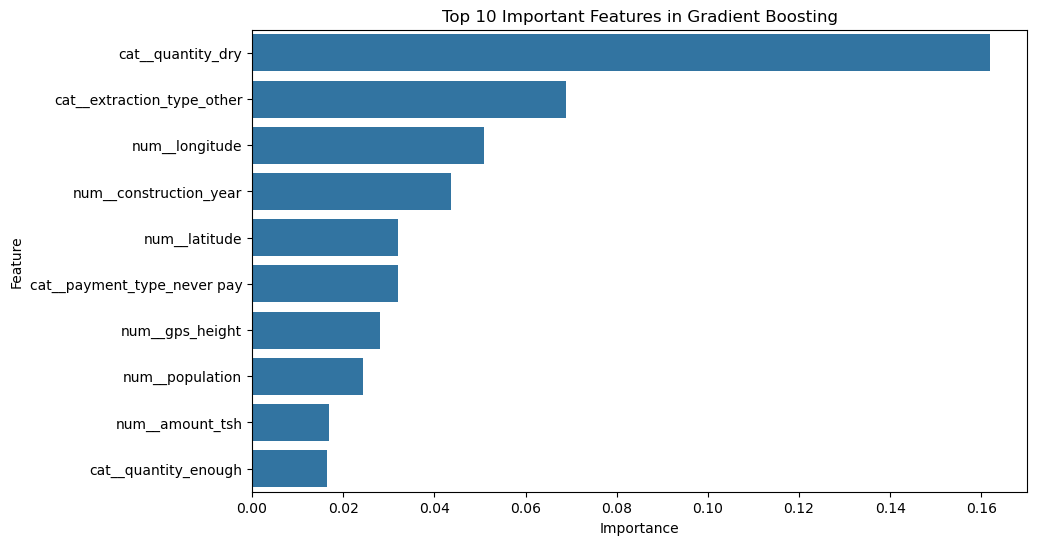

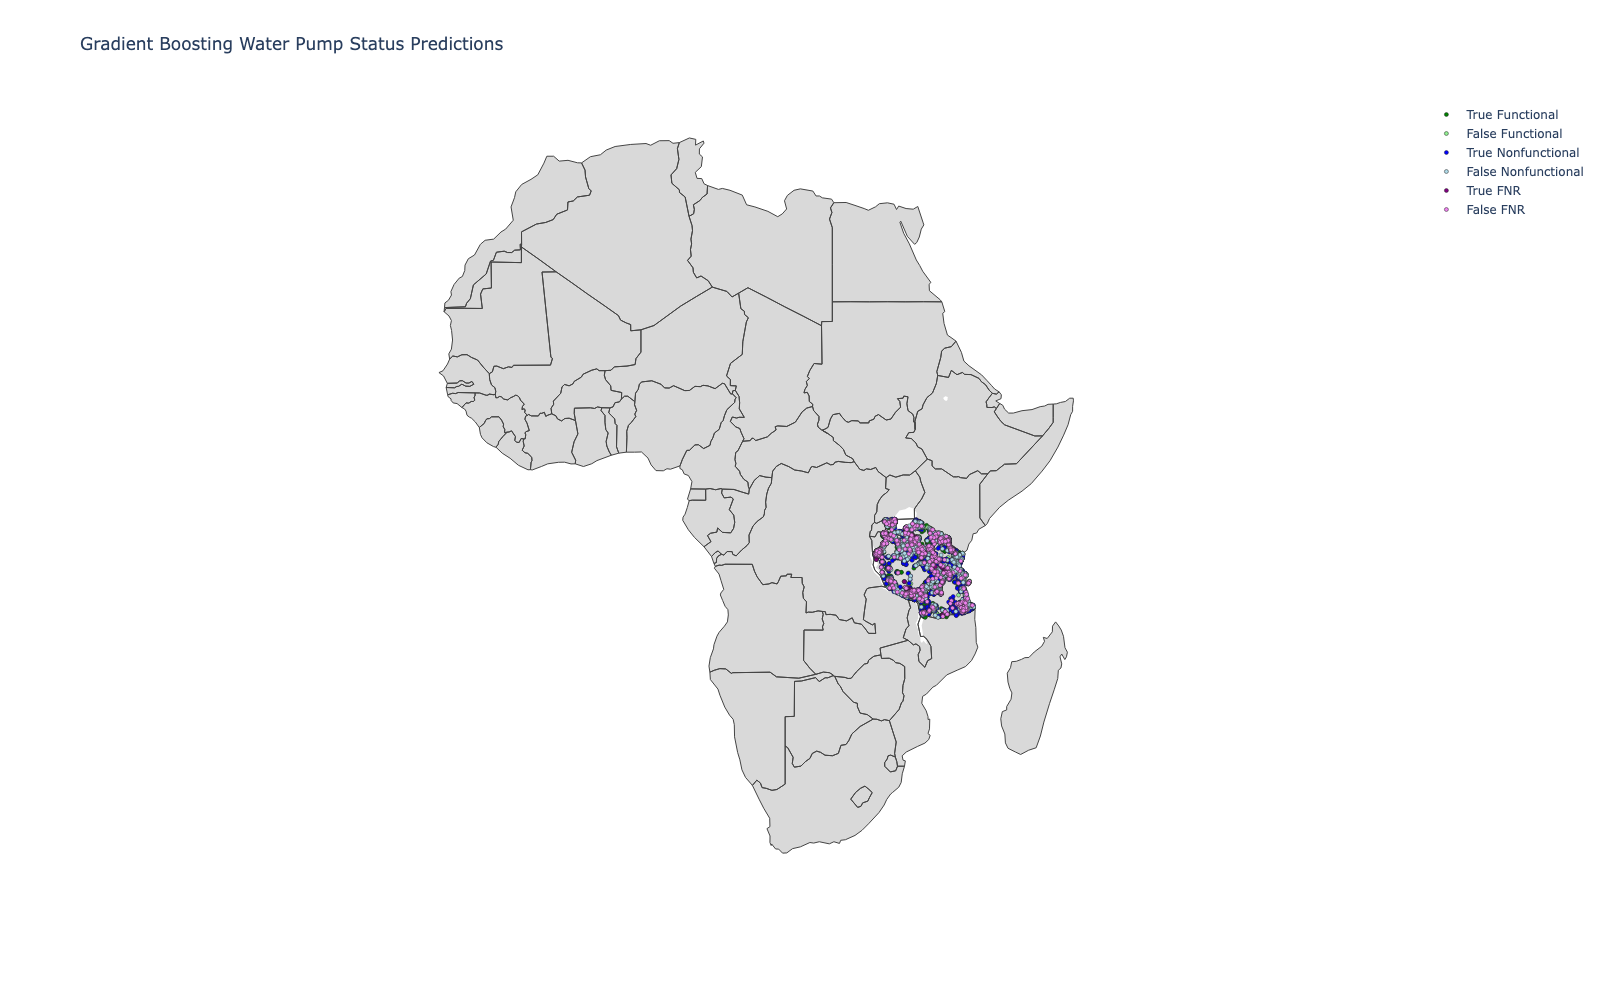

In [57]:
# Evaluation
print("Gradient Boosting Classifier Report:\n")
print(classification_report(y_test, y_test_pred_gb, target_names=class_names))

# Confusion Matrix with Percentages
cm_gb = confusion_matrix(y_test, y_test_pred_gb)
cm_gb_percentage = cm_gb.astype('float') / cm_gb.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_gb_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gradient Boosting Confusion Matrix with Percentage')
plt.show()

# Feature Importance Visualization
importances_gb = gb_classifier.feature_importances_
importance_gb_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_gb_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features in Gradient Boosting')
plt.show()

# Plot on Map
plot_predictions(X_test, y_test, y_test_pred_gb, 'Gradient Boosting Water Pump Status Predictions', categories_colors, 'africa', 1500, 1000)

### Support Vector Machine (SVM)
- SVM is a powerful algorithm for classification tasks. We'll experiment with linear and non-linear kernels to find the best separation boundary.

In [32]:
# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, random_state=42)  # Using RBF kernel and default C value

# Fit the classifier to the training data
svm_classifier.fit(X_train_preprocessed, y_train)

# Predict on the validation set
y_test_pred_svm = svm_classifier.predict(X_test_preprocessed)

SVM Classifier Report:

                         precision    recall  f1-score   support

             functional       0.76      0.93      0.83      6457
         non functional       0.67      0.19      0.30       851
functional needs repair       0.85      0.70      0.77      4572

               accuracy                           0.79     11880
              macro avg       0.76      0.60      0.63     11880
           weighted avg       0.79      0.79      0.77     11880



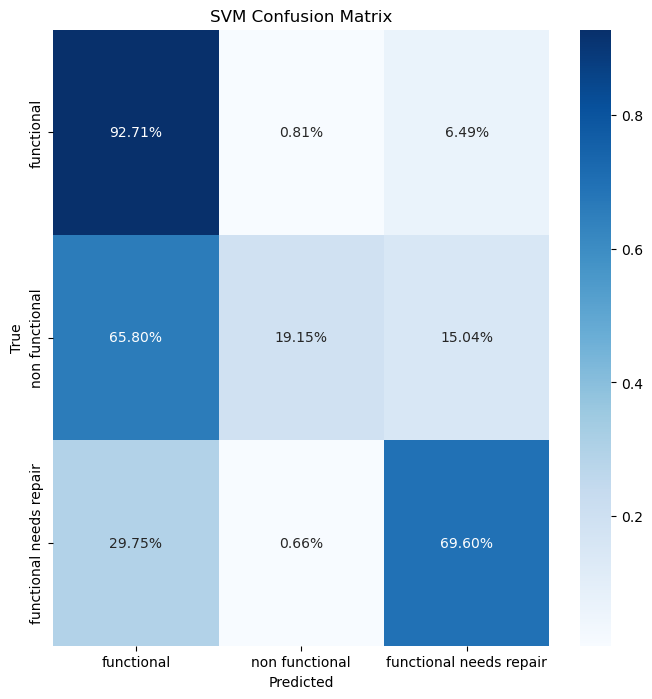

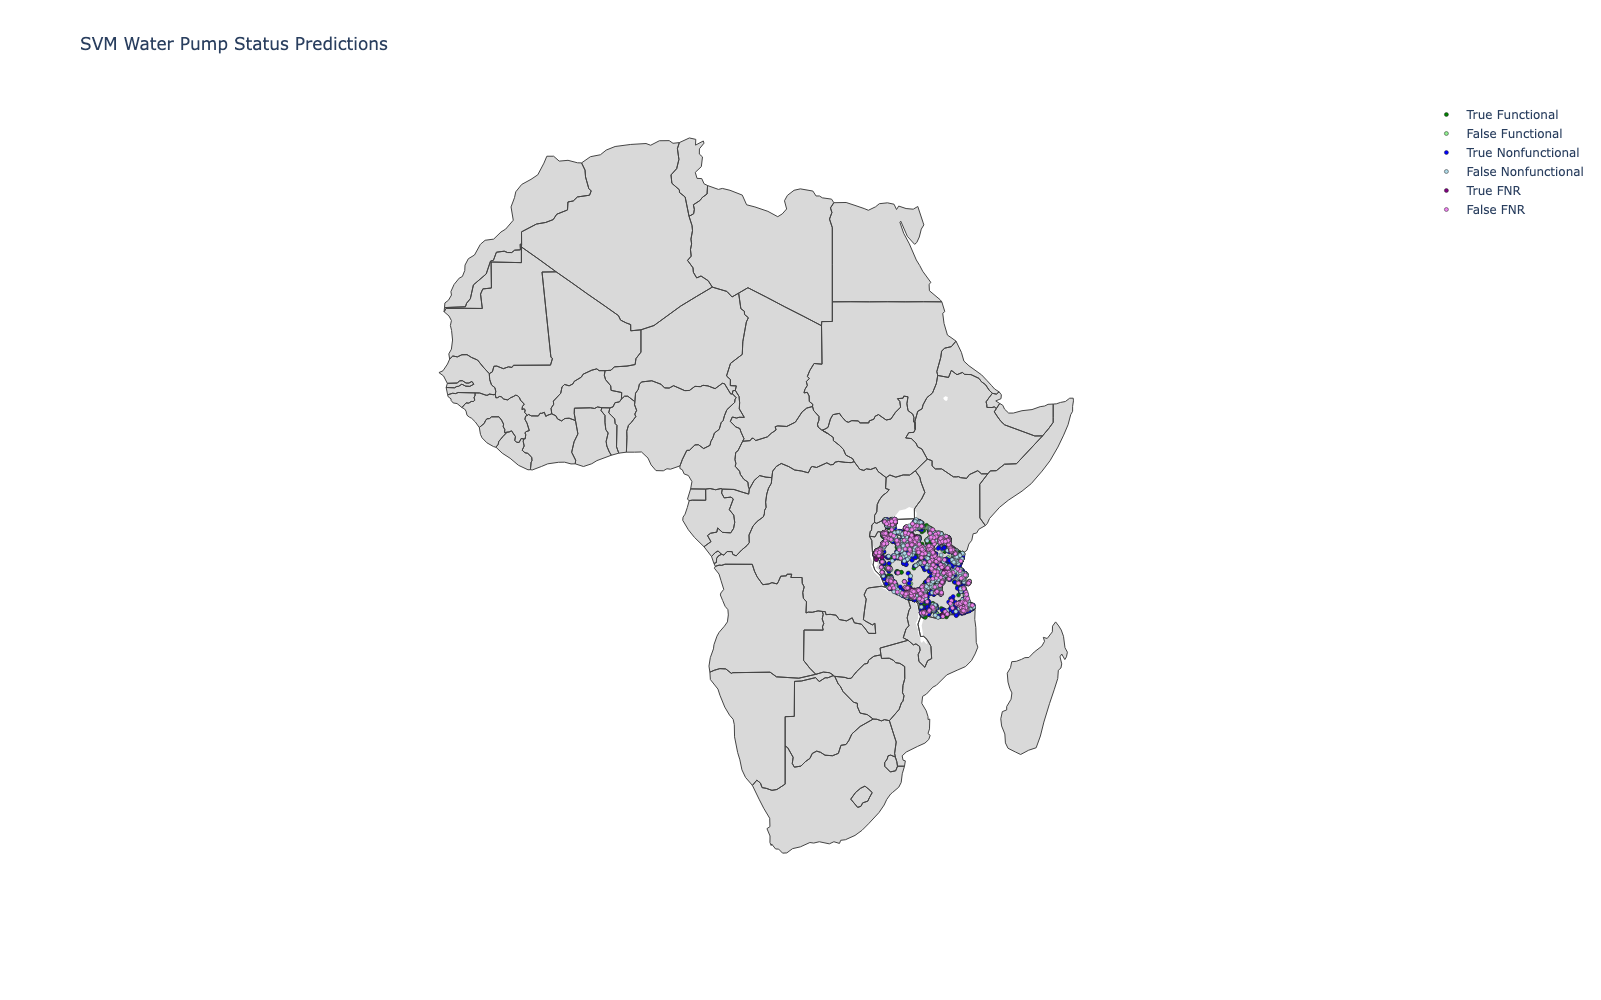

In [34]:
# Evaluation Report
print("SVM Classifier Report:\n")
print(classification_report(y_test, y_test_pred_svm, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(8, 8))
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
cm_svm_percentage = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_svm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

# Plot on Map
plot_predictions(X_test, y_test, y_test_pred_svm, 'SVM Water Pump Status Predictions', categories_colors, 'africa', 1500, 1000)

### KNN
- K-Nearest Neighbors (KNN) is a simple, yet effective, machine learning algorithm that classifies a data point based on the majority class of its nearest neighbors. It is particularly suitable for this task of categorizing water pumps, as it can handle non-linear data and is effective in classifying instances based on similarity in feature space, which is likely to be a key factor in determining the functionality of water pumps.

In [48]:
# Instantiate the KNN classifier(try varying n_neighbors)
knn_classifier = KNeighborsClassifier(weights='distance', n_jobs=-1)

# Define the parameter grid: try different values for n_neighbors
param_grid = {'n_neighbors': range(1, 15, 3)}

# Initialize CV
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Fit the classifier to the training data
grid_search.fit(X_train_preprocessed, y_train)

# Find the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best score found: ", best_score)

# Use the best parameters to predict on the validation set
y_test_pred_knn = grid_search.predict(X_test_preprocessed)

Best parameters found:  {'n_neighbors': 10}
Best score found:  0.761683922896547


KNN Classifier Report:

                         precision    recall  f1-score   support

             functional       0.79      0.85      0.82      6457
         non functional       0.50      0.34      0.41       851
functional needs repair       0.78      0.75      0.77      4572

               accuracy                           0.77     11880
              macro avg       0.69      0.65      0.66     11880
           weighted avg       0.77      0.77      0.77     11880



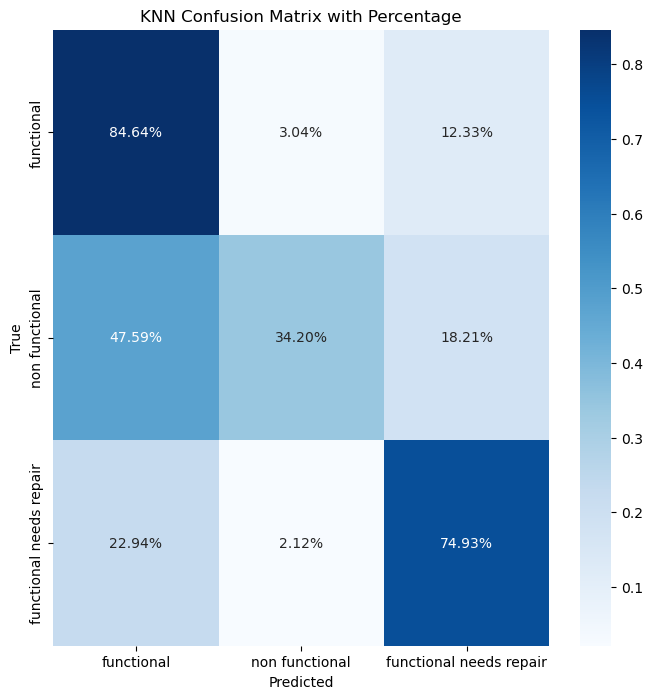

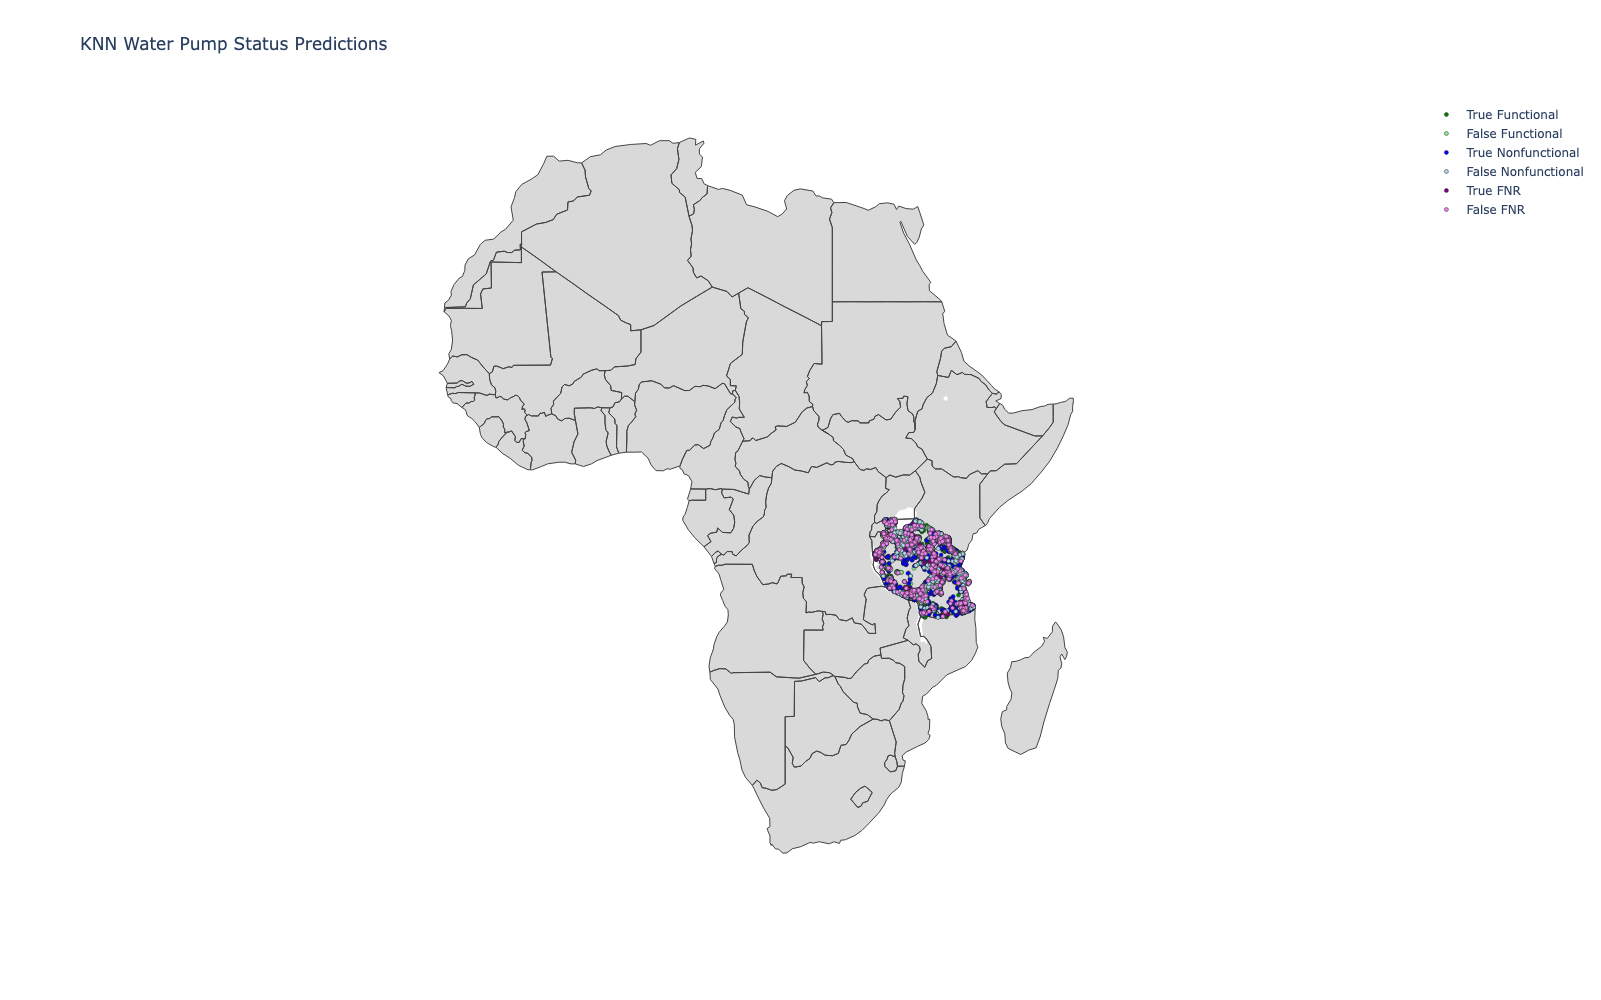

In [49]:
# Evaluation
print("KNN Classifier Report:\n")
print(classification_report(y_test, y_test_pred_knn, target_names=class_names))

# Confusion Matrix with Percentages
plt.figure(figsize=(8, 8))
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
cm_knn_percentage = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_knn_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix with Percentage')
plt.show()

# Plot on Map
plot_predictions(X_test, y_test, y_test_pred_knn, 'KNN Water Pump Status Predictions', categories_colors, 'africa', 1500, 1000)

In [51]:
res = grid_search.cv_results_
param_scores = list((zip(res["rank_test_score"],res["mean_test_score"],res["params"], )))
param_scores.sort(key=lambda x: x[0])
param_scores

[(1, 0.761683922896547, {'n_neighbors': 10}),
 (2, 0.7605097470442382, {'n_neighbors': 13}),
 (3, 0.7600347224444259, {'n_neighbors': 7}),
 (4, 0.7569503389810223, {'n_neighbors': 4}),
 (5, 0.7418997801466645, {'n_neighbors': 1})]